In [120]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
small_bouts_df = pd.read_csv('/home/welling/Downloads/bouts (8).tsv', sep='\t')

In [4]:
small_bouts_df

,boutId,tourneyId,leftWins,leftPlayerId,rightPlayerId,rightWins,draws,note
0,5,3,2,7,6,1,0,NaN
1,6,3,1,6,8,1,0,NaN
2,7,3,1,6,12,1,0,NaN
3,8,3,0,6,9,1,0,NaN
4,9,3,2,6,10,3,1,NaN
5,10,3,2,6,11,0,0,NaN
6,11,3,2,7,8,2,0,NaN
7,12,3,2,7,12,0,0,NaN
8,13,3,1,7,10,1,0,NaN
9,14,3,2,7,11,1,0,NaN


In [159]:
n_players = 10
player_wts = np.zeros(n_players, dtype=float)

In [160]:
for i in range(n_players):
    player_wts[i] = i+1

In [179]:
npairs = 4000
outcomes = []
for pair in range(npairs):
    l_player = np.random.choice(range(n_players))
    r_player = np.random.choice(range(n_players-1))
    if r_player >= l_player:
        r_player += 1
    l_prob = player_wts[l_player] / (player_wts[l_player] + player_wts[r_player])
    if np.random.random() <= l_prob:
        outcomes.append({'l_player':l_player, 'r_player':r_player, 'l_wins':1, 'r_wins':0})
    else:
        outcomes.append({'l_player':l_player, 'r_player':r_player, 'l_wins':0, 'r_wins':1})
outcomes_df = pd.DataFrame(outcomes)

In [180]:
outcomes_df.head()

,l_player,r_player,l_wins,r_wins
0,6,4,0,1
1,7,2,1,0
2,9,8,0,1
3,7,4,1,0
4,5,7,0,1


In [181]:
totals_df = outcomes_df.groupby(['l_player','r_player']).sum()

In [182]:
totals_df = totals_df.reset_index()

In [183]:
totals_df

,l_player,r_player,l_wins,r_wins
0,0,1,12,24
1,0,2,9,36
2,0,3,9,42
3,0,4,8,47
4,0,5,6,40
...,...,...,...,...
85,9,4,28,13
86,9,5,29,18
87,9,6,29,19
88,9,7,29,20


In [184]:
totals_df[totals_df['l_player']==1]

,l_player,r_player,l_wins,r_wins
9,1,0,22,19
10,1,2,18,25
11,1,3,15,23
12,1,4,11,36
13,1,5,11,25
14,1,6,9,38
15,1,7,4,32
16,1,8,4,35
17,1,9,11,38


In [185]:
totals_df[totals_df['r_player']==1]

,l_player,r_player,l_wins,r_wins
0,0,1,12,24
19,2,1,27,18
28,3,1,40,23
37,4,1,23,14
46,5,1,40,14
55,6,1,43,8
64,7,1,35,7
73,8,1,29,11
82,9,1,39,3


In [197]:
def reorder_df(raw_df):
    merge_df_a = raw_df.rename(columns={'l_player':'player', 'r_player':'opponent', 'l_wins':'wins', 'r_wins':'losses'})
    merge_df_a['bouts'] = merge_df_a['wins'] + merge_df_a['losses']
    merge_df_b = raw_df.rename(columns={'r_player':'player', 'l_player':'opponent', 'r_wins':'wins', 'l_wins':'losses'})
    merge_df_b['bouts'] = merge_df_b['wins'] + merge_df_b['losses']
    return pd.concat([merge_df_a, merge_df_b], axis=0).groupby(['player','opponent']).sum().reset_index()

In [189]:
def initialize(nWts):
    return np.ones(nWts)

In [190]:
def mutate(w_vec, idx, rng, sigma=1.0):
    norm_samp = rng.standard_normal(size=1)
    scale_fac = np.exp(norm_samp)
    rslt = w_vec.copy()
    rslt[idx] *= scale_fac
    return rslt

In [191]:
def calc_p_ratio(idx, old_wts, new_wts, samples_df):
    p_ratio = 1.0
    w = old_wts[idx]
    wprime = new_wts[idx]
    #print(f"idx {idx}: {w} -> {wprime}:")
    for rowidx, row in samples_df[samples_df.player==idx].iterrows():
        #print(row)
        op_idx = row['opponent']
        w_op = old_wts[op_idx]
        old_p_ratio = p_ratio
        p_ratio *= np.power(wprime / w, row['wins'])
        p_ratio *= np.power((w + w_op)/(wprime + w_op), row['bouts'])
        #print(f"  opponent={row['player']}, weight_opponent={w_op} p_ratio: {old_p_ratio} -> {p_ratio}")
    return p_ratio

In [192]:
def calc_p_ratio(idx, old_wts, new_wts, samples_df):
    tot = 0.0
    w = old_wts[idx]
    wprime = new_wts[idx]
    log_w_ratio = np.log(wprime/w)
    for rowidx, row in samples_df[samples_df.player==idx].iterrows():
        #print(row)
        op_idx = row['opponent']
        w_op = old_wts[op_idx]
        tot += row['wins'] * log_w_ratio
        tot += row['bouts'] * np.log((w + w_op)/(wprime + w_op))
    return np.exp(tot)

In [201]:
def sweep(w_vec, win_loss_df, rng, sigma):
    for idx in range(len(w_vec)):
        new_w_vec = mutate(w_vec, idx, rng, sigma=sigma)
        p_ratio = calc_p_ratio(idx, w_vec, new_w_vec, win_loss_df)
        if np.random.random() <= p_ratio:
            w_vec = new_w_vec
    return w_vec

In [202]:
burnin_sweeps = 1000
n_samp = 100
sweeps_per_samp = 100
rng = np.random.default_rng()
n_players = len(player_wts)  # we are trying to infer player_wts
w_vec = initialize(n_players)
reordered_df = reorder_df(totals_df)
# burn-in
for iter in range(burnin_sweeps):
    w_vec = sweep(w_vec, reordered_df, rng, sigma=0.1)
    w_vec /= w_vec[0]  # rescale
    #print(iter, w_vec)
print('burn-in complete')
samp_l = []
for samp in range(n_samp):
    for iter in range(sweeps_per_samp):
        w_vec = sweep(w_vec, reordered_df, rng, sigma=0.1)
        w_vec /= w_vec[0]  # rescale
    samp_l.append(w_vec.copy())
    print(samp)


burn-in complete
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [203]:
samp_array = np.empty((len(samp_l), len(samp_l[0])))
for idx, vec in enumerate(samp_l):
    samp_array[idx, :] = vec

AxesSubplot(0.125,0.125;0.775x0.755)


<ipython-input-204-b94447bfe202>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


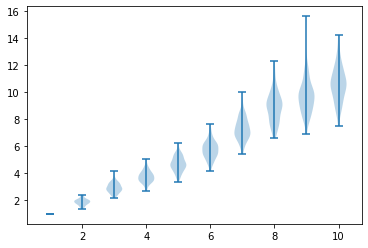

In [204]:
fig, axes = plt.subplots(ncols=1, nrows=1)
print(axes)
axes.violinplot(samp_array)
fig.show()

AxesSubplot(0.125,0.125;0.775x0.755)


<ipython-input-178-b94447bfe202>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


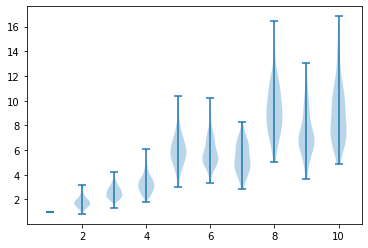

In [178]:
fig, axes = plt.subplots(ncols=1, nrows=1)
print(axes)
axes.violinplot(samp_array)
fig.show()

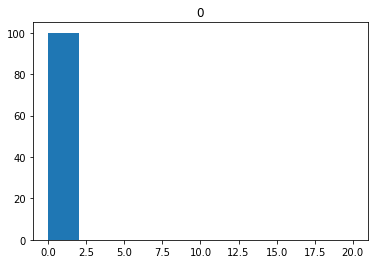

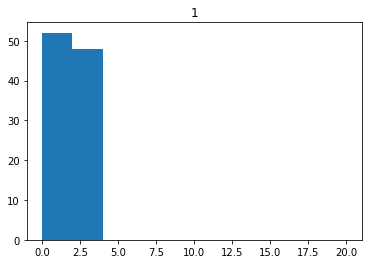

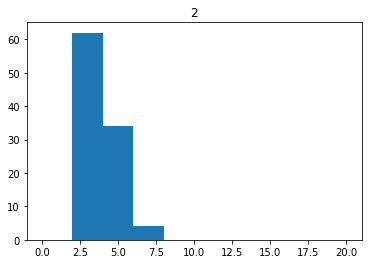

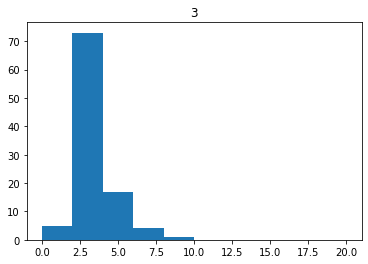

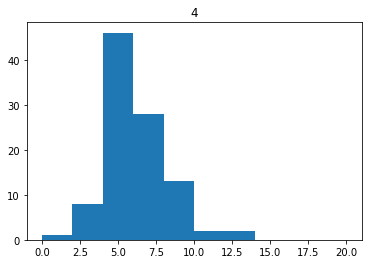

In [143]:
for idx in range(n_players):
    plt.title(idx)
    plt.hist([v[idx] for v in samp_l], range=[0.0, 20.0])
    plt.show()

In [125]:
rng = np.random.default_rng()
for i in range(7):
    w_vec = mutate(w_vec, 3, rng, sigma=0.2)
    print(w_vec)

[1.00000000e+00 3.15354013e+00 2.92204429e+00 4.30306593e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 8.19315573e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 9.05832120e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 1.57036131e+02
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 1.80674142e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 3.91368396e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 2.73565981e+01
 2.37436278e+01

In [38]:
rng = np.random.default_rng()
print(rng.standard_normal(size=100))

[ 4.62751278e-02  1.92739976e-02  2.78453598e-01  5.56477021e-01
  1.50966000e+00 -8.59554544e-01 -4.12515716e-01 -4.90642342e-01
 -7.46452047e-02 -7.80648762e-01  1.39380560e-01  9.16690735e-01
  7.45714988e-02 -3.56676673e-01 -1.60829870e+00 -1.50534317e+00
 -7.60107090e-01  1.75279543e-03 -6.61985602e-01 -4.68890654e-01
 -1.25296501e+00 -5.55339603e-01 -1.14217426e+00 -6.26829145e-01
 -1.07976453e+00 -6.18942823e-02  1.69316490e-01  3.09991587e-01
 -1.57735870e-01  1.07652204e+00 -4.08117920e-01 -1.06473028e+00
 -1.12165387e+00 -3.00579397e-01  6.64806317e-03 -8.18626754e-01
  7.17753204e-01 -1.94787020e-01  4.43364966e-01 -2.54610208e+00
  3.45116098e-03  3.75138695e-01  7.27154067e-01  1.11486866e+00
  3.01304508e-01 -6.01177562e-02 -3.39415303e-01  1.91238957e-01
 -3.94445151e-01 -1.21892141e+00 -4.78977608e-01  1.37289827e+00
  3.57562885e-01  1.54901666e+00 -9.30178446e-01 -8.82320579e-01
 -1.11705626e+00 -2.44797777e-01  1.16731784e-01 -1.67903976e-01
  2.88643286e-01 -1.05303